# Analytics: Which boroughs' stations needed help most often?

In [1]:
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
database_host='10.152.29.90'

In [3]:
def get_connection(host = "localhost",schema="" ):
    
    conn = psycopg2.connect("dbname='proj001_lfb' user='postgres' "
                            "host=" + host )
    if schema:
        cur = conn.cursor()
        query = "SET search_path TO {}".format(schema)
        cur.execute(query)

    return conn

# Create a dataframe for analytics

In [4]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_incidents '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_incidents = pd.read_sql(qry, conn)  
df_incidents.head()

,id,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,num_stations_with_pumps_attending,num_pumps_attending
0,1,79398141,2014-06-22 10:21:15,2,21,108386,OVERTHEBORDER,None,None
1,2,168174131,2013-12-07 04:29:07,6,21,108387,OVERTHEBORDER,None,None
2,3,167600111,2011-10-14 11:58:03,1,21,108388,BROMLEY,2,2
3,4,107752141,2014-08-12 16:48:29,6,30,108388,BROMLEY,2,3
4,5,61181121,2012-05-03 19:53:30,1,18,108388,BROMLEY,1,2


Convert to correct types

In [5]:
df_incidents.dtypes

id                                            int64
incidentnumber_cln                           object
dateofcall_cln                       datetime64[ns]
id_incident_type                              int64
id_property                                   int64
id_postcode                                   int64
incident_station_ground                      object
num_stations_with_pumps_attending            object
num_pumps_attending                          object
dtype: object

In [6]:
pd.to_datetime(df_incidents['dateofcall_cln'])

# Convert to integer
df_incidents['num_stations_with_pumps_attending']=df_incidents['num_stations_with_pumps_attending'].replace(np.nan,'0',regex=True)
df_incidents['num_stations_with_pumps_attending']=df_incidents['num_stations_with_pumps_attending'].astype('int')

# Convert to integer
df_incidents['num_pumps_attending']=df_incidents['num_pumps_attending'].replace(np.nan,'0',regex=True)
df_incidents['num_pumps_attending']=df_incidents['num_pumps_attending'].astype('int')

df_incidents.set_index('id')

print(df_incidents.dtypes)
df_incidents.head()


id                                            int64
incidentnumber_cln                           object
dateofcall_cln                       datetime64[ns]
id_incident_type                              int64
id_property                                   int64
id_postcode                                   int64
incident_station_ground                      object
num_stations_with_pumps_attending             int64
num_pumps_attending                           int64
dtype: object


,id,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,num_stations_with_pumps_attending,num_pumps_attending
0,1,79398141,2014-06-22 10:21:15,2,21,108386,OVERTHEBORDER,0,0
1,2,168174131,2013-12-07 04:29:07,6,21,108387,OVERTHEBORDER,0,0
2,3,167600111,2011-10-14 11:58:03,1,21,108388,BROMLEY,2,2
3,4,107752141,2014-08-12 16:48:29,6,30,108388,BROMLEY,2,3
4,5,61181121,2012-05-03 19:53:30,1,18,108388,BROMLEY,1,2


## Extract and cast the postcodes data

In [7]:
qry = ("select *"
           "from proj001_lfb_1_0_0.l3_postcodes "
            " ;")
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_postcodes = pd.read_sql(qry, conn)  
df_postcodes.set_index('id')
df_postcodes.head(20)


,id,postcode_full,postcode_district,incgeo_boroughname,incgeo_wardname,incgeo_wardnamenew,frs
0,1,AL1 3EA,AL1,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
1,2,AL2 1QY,AL2,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
2,3,AL8 7QA,AL8,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
3,4,BR1 1AB,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
4,5,BR1 1AE,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
5,6,BR1 1BQ,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
6,7,BR1 1BW,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
7,8,BR1 1BY,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
8,9,BR1 1DD,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
9,10,BR1 1DE,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON


In [8]:
df_postcodes.dtypes

id                     int64
postcode_full         object
postcode_district     object
incgeo_boroughname    object
incgeo_wardname       object
incgeo_wardnamenew    object
frs                   object
dtype: object

## Join incidents to postcodes

In [9]:
df_analytics = pd.merge(df_incidents,
                        df_postcodes[['id','postcode_full', 'incgeo_boroughname', 'incgeo_wardname','frs']],
                        how='left', left_on='id_postcode', right_on='id')
df_analytics.drop(['id_postcode','id_y','id_x'], axis=1, inplace=True)
df_analytics.head(5)

,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,incident_station_ground,num_stations_with_pumps_attending,num_pumps_attending,postcode_full,incgeo_boroughname,incgeo_wardname,frs
0,79398141,2014-06-22 10:21:15,2,21,OVERTHEBORDER,0,0,None,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
1,168174131,2013-12-07 04:29:07,6,21,OVERTHEBORDER,0,0,None,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
2,167600111,2011-10-14 11:58:03,1,21,BROMLEY,2,2,None,BROMLEY,BICKLEY,LONDON
3,107752141,2014-08-12 16:48:29,6,30,BROMLEY,2,3,None,BROMLEY,BICKLEY,LONDON
4,61181121,2012-05-03 19:53:30,1,18,BROMLEY,1,2,None,BROMLEY,BICKLEY,LONDON


# Which boroughs required most help from other stations?

In [10]:
df_boroughs_needing_help = df_analytics.loc[df_analytics['num_stations_with_pumps_attending'] > 1][['incgeo_boroughname','num_stations_with_pumps_attending']]
print(df_boroughs_needing_help.shape)

df_by_borough=df_boroughs_needing_help.groupby(['incgeo_boroughname'], as_index=False).count().sort_values(by='num_stations_with_pumps_attending', ascending=False)
df_by_borough.columns = ['incgeo_boroughname','incidents_needing_help']


df_by_borough.head()


(293018, 2)


,incgeo_boroughname,incidents_needing_help
33,WESTMINSTER,16155
6,CAMDEN,16073
28,SOUTHWARK,15172
23,LEWISHAM,13943
30,TOWER HAMLETS,13157


Visualize the results

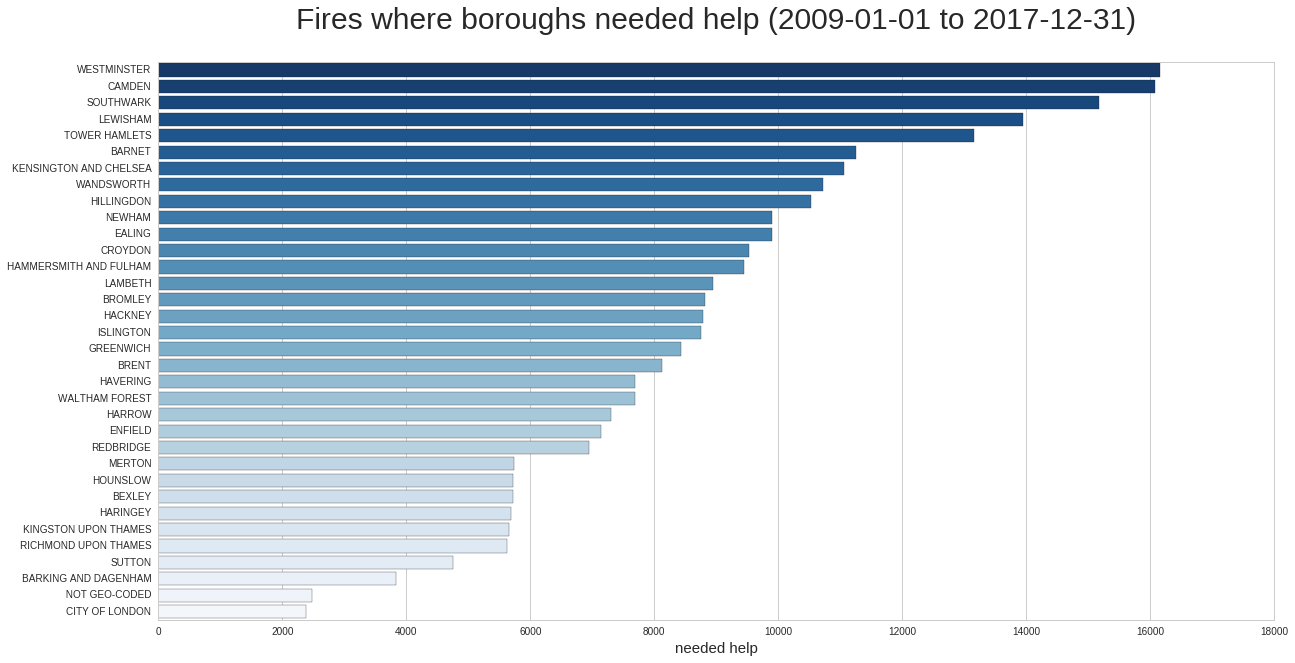

In [11]:
# calculate date range for the title
from_date = min(df_analytics['dateofcall_cln']).to_pydatetime().date()
to_date = max(df_analytics['dateofcall_cln']).to_pydatetime().date()
title = "Fires where boroughs needed help (" + str(from_date) + ' to ' + str(to_date) + ")"

sns.set(style="whitegrid")
sns.set_color_codes("muted")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# plot counts of help needed with a reversed Blues palette
ax = sns.barplot(y="incgeo_boroughname", x="incidents_needing_help", data=df_by_borough, palette='Blues_r')
ax.set_title(title,fontsize=30)
ax.set_xlabel('needed help',fontsize=15)
ax.set_ylabel('',fontsize=30)
ax.title.set_position([.5, 1.05])


# Store results in database for reference later
Create workproduct space in the database

In [12]:

engine = create_engine('postgresql://postgres@'+database_host+':5432/proj001_lfb')
conn = engine.connect()

sql = text('drop schema if exists wp_004_event_analytics_02 cascade;')
conn.execute(sql)

sql = text('create schema if not exists wp_004_event_analytics_02;' )
conn.execute(sql)



In [13]:
df_by_borough.to_sql(name='df_by_borough',con= engine,schema ='wp_004_event_analytics_02')

# How has new data changed the rankings?
Because we keep version of workproduct results in our datastore, it is easy to diff earlier workproduct results and perhaps explain any differences.

In [25]:
sql = text( "select  "
"older.incgeo_boroughname "
",older.incidents_needing_help	as incidents_needing_help_older "
",older.old_rank "
",newer.incidents_needing_help	as incidents_needing_help_newer "
",newer.new_rank "
"from"
"("
"	select "
	"rank() over (order by  incidents_needing_help desc) old_rank "
	",* "
    "from wp_004_event_analytics_01.df_by_borough "
") older "
"left join "
"( "
	"select "
    "rank() over (order by  incidents_needing_help desc) new_rank "
	",* "
	"from wp_004_event_analytics_02.df_by_borough "
") newer "
"on "
"older.incgeo_boroughname = newer.incgeo_boroughname "
"where older.old_rank != newer.new_rank "
"order by old_rank asc"
          )

df_difference = pd.read_sql(sql,conn)
df_difference


,incgeo_boroughname,incidents_needing_help_older,old_rank,incidents_needing_help_newer,new_rank
0,CAMDEN,8844,1,16073,2
1,WESTMINSTER,8579,2,16155,1
2,WANDSWORTH,5196,7,10728,8
3,HILLINGDON,4931,8,10522,9
4,HAMMERSMITH AND FULHAM,4917,9,9447,13
5,KENSINGTON AND CHELSEA,4748,10,11065,7
6,CROYDON,4696,11,9523,12
7,GREENWICH,4672,12,8425,18
8,LAMBETH,4502,13,8946,14
9,BROMLEY,4423,14,8819,15
